# 一、 数据集信息

## 1. 数据来源：阿里云天池（[Tianchi]( https://tianchi.aliyun.com/dataset/649 ))
## 2. 数据集内容：
|文件名称|说明|包含特征|
|:---|:----|:---|
|UserBehavior.csv|包含所有的用户行为数据|用户ID，商品ID，商品类目ID，行为类型，时间戳|

**字段说明**

|列名称|说明|
|:---|:---|
|用户ID|整数类型，序列化后的用户ID|
|商品ID|整数类型，序列化后的商品ID|
|商品类目ID|整数类型，序列化后的商品所属类目ID|
|行为类型|字符串，枚举类型，包括('pv', 'buy', 'cart', 'fav')|
|时间戳|行为发生的时间戳|

注意到，用户行为类型共有四种，它们分别是

|行为类型|说明|
|:---|:---|
|pv|商品详情页pv，等价于点击|
|buy|商品购买|
|cart|将商品加入购物车|
|fav|收藏商品|
## 3. 数据集大小
|维度|数量|
|:---|:---|
|用户数量|987,994|
|商品数量|4,162,024|
|用户数量|987,994|
|商品类目数量|9,439|
|所有行为数量|100,150,807|

# 二、 数据清洗

In [1]:
# 导入必要的包
import pandas as pd
import numpy as np

In [2]:
# 加载数据集
user_data = pd.read_csv('UserBehavior.csv',header=None)

In [3]:
# 查看数据信息
user_data.info()
user_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150807 entries, 0 to 100150806
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   0       int64 
 1   1       int64 
 2   2       int64 
 3   3       object
 4   4       int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


,0,1,2,3,4
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [4]:
# 列名矫正
user_data.columns = ['用户ID', '商品ID', '商品类目ID', '行为类型', '时间戳']
user_data.head()

,用户ID,商品ID,商品类目ID,行为类型,时间戳
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [5]:
# 缺失值检查
user_data.isnull().sum()

用户ID      0
商品ID      0
商品类目ID    0
行为类型      0
时间戳       0
dtype: int64

In [6]:
# 重复值检查
user_data.duplicated().sum()

49

In [7]:
# 重复值处理
user_data.drop_duplicates(inplace=True)

In [8]:
# 异常值检测与处理
valid_values = {'pv', 'buy', 'cart', 'fav'}
invalid_mask = ~user_data['行为类型'].isin(valid_values)
invalid_user = user_data[invalid_mask]
invalid_user

,用户ID,商品ID,商品类目ID,行为类型,时间戳


In [9]:
# 日期格式转换
user_data['时间戳'] = pd.to_datetime(user_data['时间戳'], unit='s', errors='coerce')

In [10]:
# 保存处理后的数据
user_data.to_csv("UserBehavior_v1.csv")

# 三、 探索性分析

In [11]:
# 导入必要的包
from IPython.display import Markdown

## 1. 用户活跃时间分布
利用PV和UV进行综合分析

In [12]:
# 转换时间戳为datetime格式，并提取小时
user_data['小时'] = user_data['时间戳'].dt.hour

# 提取星期
user_data['星期'] = user_data['时间戳'].dt.day_name()
user_data.head()


,用户ID,商品ID,商品类目ID,行为类型,时间戳,小时,星期
0,1,2268318,2520377,pv,2017-11-24 17:21:10,17,Friday
1,1,2333346,2520771,pv,2017-11-24 22:15:33,22,Friday
2,1,2576651,149192,pv,2017-11-25 01:21:25,1,Saturday
3,1,3830808,4181361,pv,2017-11-25 07:04:53,7,Saturday
4,1,4365585,2520377,pv,2017-11-25 07:49:06,7,Saturday


In [13]:
# 统计每小时的浏览行为（PV）总量
hourly_pv = user_data[user_data['行为类型'] == 'pv'].groupby('小时').size().reset_index(name='PV')

#按PV量降序排序
hourly_pv_sorted = hourly_pv.sort_values('PV', ascending=False)
hourly_pv_sorted.head()

,小时,PV
13,13,7544178
14,14,7450304
12,12,6590521
15,15,5612303
11,11,5434314


In [14]:
# 统计每天的浏览行为（PV）总量
daily_pv = user_data[user_data['行为类型'] == 'pv'].groupby('星期').size().reset_index(name='PV')

#按PV量降序排序
daily_pv_sorted = daily_pv.sort_values('PV', ascending=False)
daily_pv_sorted.head()

,星期,PV
2,Saturday,21911434
3,Sunday,20186364
0,Friday,11107275
4,Thursday,9448777
6,Wednesday,9243866


In [15]:
# 统计每小时的独立用户数
hourly_uv = user_data[user_data['行为类型'] == 'pv'].groupby('小时')['用户ID'].nunique().reset_index(name='UV')

# 按UV量降序排序
hourly_uv_sorted = hourly_uv.sort_values('UV', ascending=False)
hourly_uv_sorted.head()

,小时,UV
13,13,662806
12,12,642223
14,14,630785
11,11,602959
7,7,581136


In [16]:
# 统计每天的独立用户数
daily_uv = user_data[user_data['行为类型'] == 'pv'].groupby('星期')['用户ID'].nunique().reset_index(name='UV')

# 按UV量降序排序
daily_uv_sorted = daily_uv.sort_values('UV', ascending=False)
daily_uv_sorted.head()

,星期,UV
2,Saturday,955593
3,Sunday,946694
0,Friday,765539
4,Thursday,711406
6,Wednesday,698687


In [17]:
peak_pv_hour = hourly_pv_sorted.iloc[0]['小时']
peak_pv_count = hourly_pv_sorted.iloc[0]['PV']

peak_uv_hour = hourly_uv_sorted.iloc[0]['小时']
peak_uv_count = hourly_uv_sorted.iloc[0]['UV']
Markdown(f"""
- **PV最高时段**: {peak_pv_hour}:00 ({peak_pv_count:,}次浏览)
- **UV最高时段**: {peak_uv_hour}:00 ({peak_uv_count:,}个独立用户)
""")


- **PV最高时段**: 13:00 (7,544,178次浏览)
- **UV最高时段**: 13:00 (662,806个独立用户)


## 2. 购买转化率
**行为路径**
- pv→buy
- pv→cart→buy
- pv→fav→buy

In [18]:
# 计算各行为类型的用户数
behavior_counts = user_data.groupby('行为类型')['用户ID'].nunique()
behavior_counts

行为类型
buy     672404
cart    738996
fav     389823
pv      984114
Name: 用户ID, dtype: int64

In [19]:
# 计算转化率指标
pv_users = behavior_counts.get('pv', 0)  # 浏览用户数
cart_users = behavior_counts.get('cart', 0)  # 加购用户数
fav_users = behavior_counts.get('fav', 0)  # 收藏用户数
buy_users = behavior_counts.get('buy', 0)  # 购买用户数

In [20]:
# 计算行为路径转化

cart_buy_users = user_data[user_data['用户ID'].isin(user_data[user_data['行为类型']=='cart']['用户ID']) & 
                (user_data['行为类型']=='buy')]['用户ID'].nunique()

fav_buy_users = user_data[user_data['用户ID'].isin(user_data[user_data['行为类型']=='fav']['用户ID']) & 
               (user_data['行为类型']=='buy')]['用户ID'].nunique()

In [21]:
Markdown(f"""
- **整体转化率：** {buy_users/pv_users:.2%}

- **加购转化率：** {cart_buy_users/cart_users:.2%}

- **收藏转化率：** {fav_buy_users/fav_users:.2%}
""")


- **整体转化率：** 68.33%

- **加购转化率：** 71.87%

- **收藏转化率：** 71.12%


## 3. 复购率

In [22]:
# 计算每个用户的购买次数
user_purchase_counts = user_data[user_data['行为类型'] == 'buy'].groupby('用户ID').size()
user_purchase_counts

用户ID
2          7
4          4
11         1
16         2
17         1
          ..
1017999    8
1018002    2
1018009    2
1018010    6
1018011    1
Length: 672404, dtype: int64

In [23]:
# 计算复购率
repeat_purchase_users = user_purchase_counts[user_purchase_counts >= 2].count()
total_purchase_users = user_purchase_counts.count()
Markdown(f"""
- ***复购率：*** {repeat_purchase_users / total_purchase_users:.2%}
""")


- ***复购率：*** 66.01%


## 4. 总结
- **用户活跃时段：** ***每天的11点——14点、每周的周六和周日***

- **复购率：** ***66.01%***

### 购买转化率

- **整体转化率：** ***68.33%***

- **加购转化率：** ***71.87%***

- **收藏转化率：** ***71.12%***

# 四、 数据可视化

In [24]:
# 导入必要的包
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
# 设置中文字体
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
mpl.rcParams['axes.unicode_minus'] = False

## 1. 用户活跃时间可视化

<Figure size 1400x600 with 0 Axes>

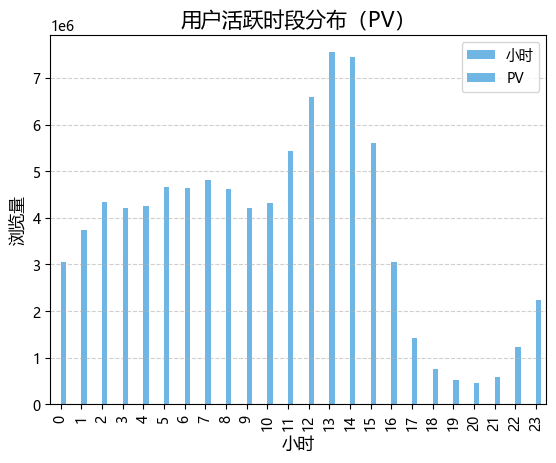

In [25]:
plt.figure(figsize=(14, 6))
hourly_pv.plot(kind='bar', color='#3498db', alpha=0.7)
plt.title('用户活跃时段分布（PV）', fontsize=15)
plt.xlabel('小时', fontsize=12)
plt.ylabel('浏览量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

<Figure size 1400x600 with 0 Axes>

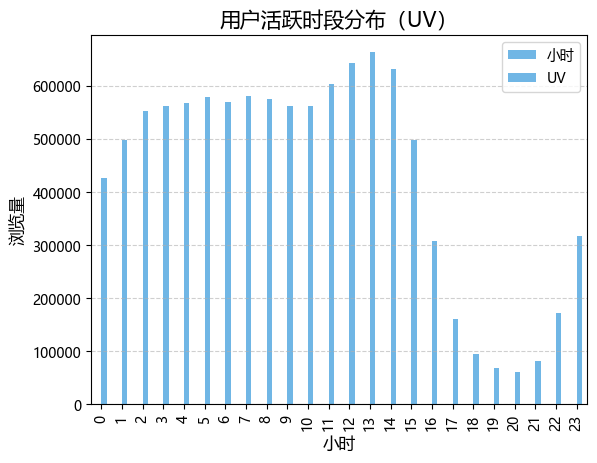

In [26]:
plt.figure(figsize=(14, 6))
hourly_uv.plot(kind='bar', color='#3498db', alpha=0.7)
plt.title('用户活跃时段分布（UV）', fontsize=15)
plt.xlabel('小时', fontsize=12)
plt.ylabel('浏览量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [27]:
# 漏斗
funnel_data = pd.DataFrame({
    '行为类型': ['浏览', '收藏', '加购', '购买'],
    '用户数': [
        user_data[user_data['行为类型']=='pv']['用户ID'].nunique(),
        user_data[user_data['行为类型']=='fav']['用户ID'].nunique(),
        user_data[user_data['行为类型']=='cart']['用户ID'].nunique(),
        user_data[user_data['行为类型']=='buy']['用户ID'].nunique()
    ]
})
funnel_data

,行为类型,用户数
0,浏览,984114
1,收藏,389823
2,加购,738996
3,购买,672404


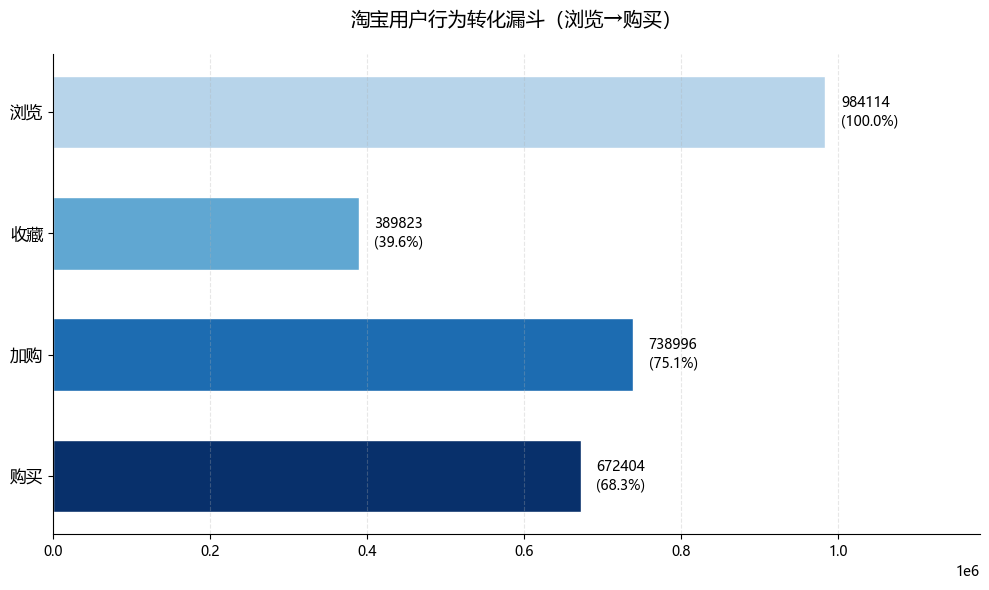

In [29]:
# 1. 计算转化率
funnel_data['转化率'] = (funnel_data['用户数'] / funnel_data['用户数'].iloc[0]).apply(lambda x: f"{x:.1%}")

# 2. 创建漏斗图
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.3, 1, len(funnel_data)))
y_pos = np.arange(len(funnel_data))

# 绘制水平条形图（漏斗效果）
bars = ax.barh(
    y_pos, 
    funnel_data['用户数'],
    color=colors,
    height=0.6,
    edgecolor='white'
)

# 3. 添加数据标签
for i, (value, rate) in enumerate(zip(funnel_data['用户数'], funnel_data['转化率'])):
    ax.text(
        value + max(funnel_data['用户数'])*0.02, 
        i,
        f"{value}\n({rate})",
        va='center',
        fontsize=10,
        color='black'
    )

# 4. 图表美化
ax.set_yticks(y_pos)
ax.set_yticklabels(funnel_data['行为类型'], fontsize=12)
ax.invert_yaxis()  # 翻转Y轴使漏斗朝上
ax.set_xlim(0, max(funnel_data['用户数'])*1.2)
ax.set_title('淘宝用户行为转化漏斗（浏览→购买）', pad=20, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()

# 五、 结论

## 1. 分析发现
- 用户活跃度在11点到14点，与通勤和休闲时间相吻合，同时用户大多在周末的活跃度最高。
- 加购转化率>收藏转化率>整体转化率
- 复购率为66.01%，显示较高的用户忠诚度。